In [60]:
### This script prepare external data(PC9, To) scatter plots and Venn diagrams for figure.py
# Author: Yiyun
import pandas as pd
from os.path import join
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from matplotlib_venn import venn2

In [42]:
### Load and read PC9 and To data
pc9_dir = '/storage/home/yur97/work/cnp_dev/out/21.0423 Lx PC9/L200only_reg_rf_boruta/anlyz'
to_dir = '/storage/home/yur97/work/cnp_dev/out/21.0506 Lx To/L200only_reg_rf_boruta/anlyz'
q3_dir = '../data/DepMap/19Q3'

df_pc9 = pickle.load(open(join(pc9_dir,'y_compr_ext.pkl'),'rb'))
df_to = pickle.load(open(join(to_dir,'y_compr_ext.pkl'),'rb'))
df_to_org = pd.read_csv(join(q3_dir,'To','ToCellCERES.csv'), index_col = 0) #original to file containing drug names

In [43]:
### Format data for plotting
#PC9
df_pc9 = pd.concat([df_pc9['actual'],df_pc9['predicted']], axis = 0).T
df_pc9.columns = ['actual','predicted']

#To, add drug names to each columns
df_to['actual'] = df_to['actual'].T ; df_to['predicted'] = df_to['predicted'].T
df_to['actual'].columns = ['actual_'+ drug for drug in df_to_org.columns]
df_to['predicted'].columns = ['predicted_'+ drug for drug in df_to_org.columns]
df_to = pd.concat([df_to['actual'],df_to['predicted']], axis = 1)

***
### Scatter plot

Text(0, 0.5, 'Predicted')

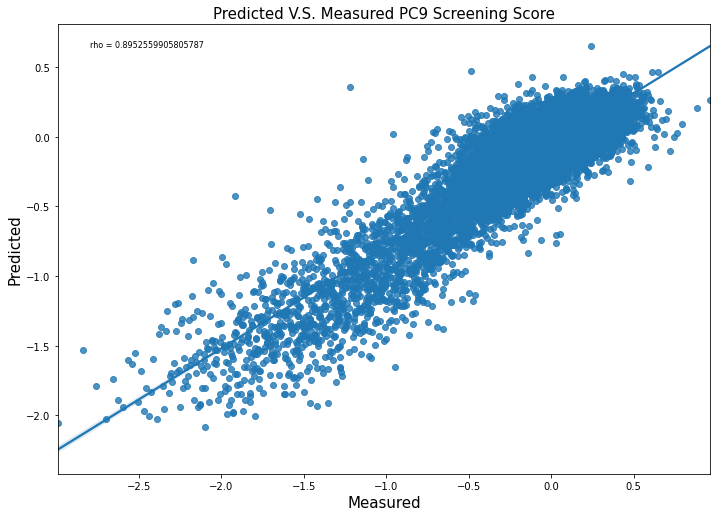

In [62]:
### Plot scatter plot
#PC9
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.regplot(x='actual', y='predicted',data = df_pc9)
corr = pearsonr(df_pc9['actual'], df_pc9['predicted'])[0]
ax.text(0.05,0.95,'rho = '+str(corr),transform=ax.transAxes,fontsize = 8) #add text
ax.set_title('Predicted V.S. Measured PC9 Screening Score', fontsize = 15)
ax.set_xlabel('Measured', fontsize=15);ax.set_ylabel('Predicted', fontsize=15)
# plt.savefig('PC9_exp_pred.pdf')

In [49]:
print(f'Pearson Correlation Coefficient for PC9 actual and predicted is:{corr}')

Pearson Correlation Coefficient for PC9 actual and predicted is:0.8952559905805787


Pearson Correlation Coefficient for DMSO actual and predicted is:0.7003534012083904
Pearson Correlation Coefficient for Met actual and predicted is:0.7187381775813444
Pearson Correlation Coefficient for Pier actual and predicted is:0.7185623049242852
Pearson Correlation Coefficient for Anti actual and predicted is:0.7401246854180487
Pearson Correlation Coefficient for Oligo actual and predicted is:0.7178098948941525
Pearson Correlation Coefficient for AO actual and predicted is:0.7282316374510382
Pearson Correlation Coefficient for EtBr actual and predicted is:0.7142712029412714
Pearson Correlation Coefficient for Chlor actual and predicted is:0.706076534124434


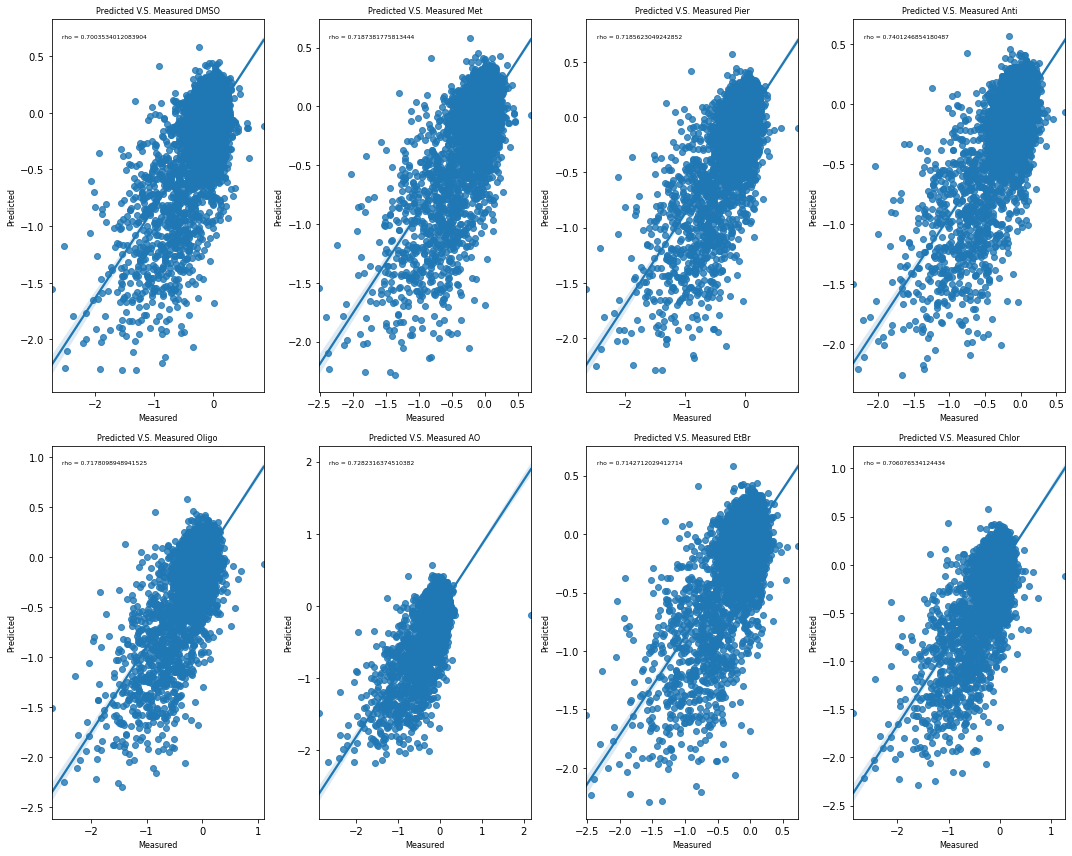

In [59]:
# Scatter plot for To
fig, axes = plt.subplots(2,4)
fig.set_size_inches(15, 12)
for i, ax in zip(range(8), axes.flat):
    drug = df_to_org.columns[i]
    sns.regplot(x='actual_'+drug, y='predicted_'+drug, data = df_to, ax = ax)
    ax.set_title('Predicted V.S. Measured '+drug, fontsize = 8)
    ax.set_xlabel('Measured', fontsize=8);ax.set_ylabel('Predicted', fontsize=8)
    corr = pearsonr(df_to['actual_'+drug], df_to['predicted_'+drug])[0]
    print(f'Pearson Correlation Coefficient for {drug} actual and predicted is:{corr}')
    ax.text(0.05,0.95,'rho = '+str(corr),transform=ax.transAxes,fontsize = 6) #add text
plt.tight_layout()
# plt.savefig('To_exp_pred.pdf')

***
### Venn diagram

In [75]:
### Function for getting hits in dataframes
def get_venn_subset(df, nhits, drug = None):

    drug = '_'+drug if drug else ''  # If given drug name

    top_actual = df['actual'+drug].T.sort_values().head(nhits).index
    top_predicted = df['predicted'+drug].T.sort_values().head(nhits).index
    intersect = len(set(top_actual).intersection(top_predicted))
    other = nhits-intersect
    
    return(other,other,intersect)

Text(0.5, 1.0, 'PC9 Predicted V.S. Measured top 100 hits')

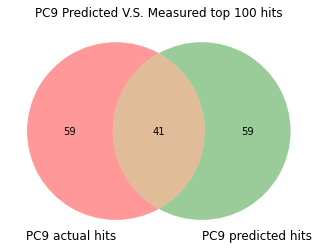

In [77]:
# PC9
fig, ax = plt.subplots()
venn_subset = get_venn_subset(df_pc9,100)
venn2(subsets = venn_subset, set_labels = ('PC9 actual hits', 'PC9 predicted hits'))
ax.set_title('PC9 Predicted V.S. Measured top 100 hits')

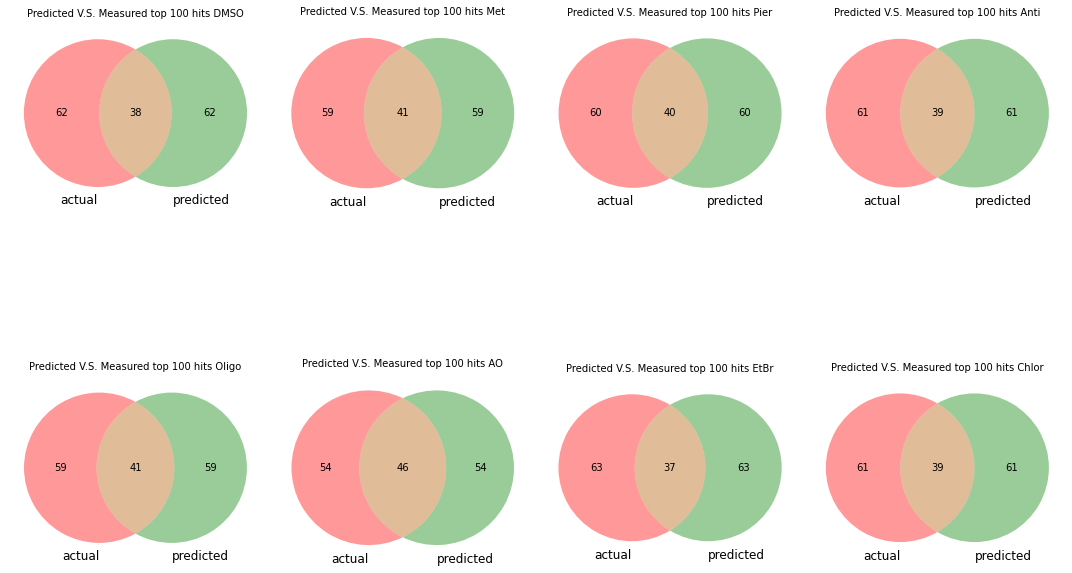

In [79]:
# To
fig, axes = plt.subplots(2,4)
fig.set_size_inches(15, 12)
for i, ax in zip(range(8), axes.flat):
    drug = df_to_org.columns[i]
    venn_subset = get_venn_subset(df_to,100, drug = drug)
    venn2(subsets = venn_subset, set_labels = ('actual', 'predicted'), ax = ax)
    ax.set_title('Predicted V.S. Measured top 100 hits '+drug, fontsize = 10)
plt.tight_layout()